In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../..')

from models.pem import pem_system
from utils import ax_default

In [2]:
surr = pem_system(init=False)

In [87]:
N = 500
r_pct = 0.9999
comp = surr['Plume']
x = surr.sample_inputs((N,), comp='Plume')
comp._model_kwargs['compress'] = False
y = comp(x, ground_truth=True)
idx = ~np.isnan(y[:, 0]) & (np.nanmax(y, axis=-1) <= 1000)
y = y[idx, :]
A = y[:, 1:]  # Data matrix, uion (N x M)

In [89]:
# Apply transform to each simulation
def g(a):
    return (a - np.mean(A, axis=0))/np.std(A, axis=0)
def g_inv(a):
    return a * np.std(A, axis=0) + np.mean(A, axis=0)
B = np.empty(A.shape)
for i in range(B.shape[0]):
    B[i, :] = g(A[i, :])

# SVD on original data
u, s, vt = np.linalg.svd(A)
frac = np.cumsum(s ** 2 / np.sum(s ** 2))
idx = int(np.where(frac >= r_pct)[0][0])
rA = idx + 1  # Number of singular values to keep
phi_A = vt[:rA, :].T  # (M x r)

# SVD on transformed data
u, s, vt = np.linalg.svd(B)
frac = np.cumsum(s ** 2 / np.sum(s ** 2))
idx = int(np.where(frac >= r_pct)[0][0])
rB = idx + 1  # Number of singular values to keep
phi_B = vt[:rB, :].T  # (M x r)
print(f'rA: {rA} rB: {rB}')

rA: 8 rB: 9


In [90]:
xt = np.array([var.nominal for var in comp.x_vars])[np.newaxis, ...]
at = comp(xt, ground_truth=True)[0, 1:]
bt = g(at)
ar = phi_A.T @ at
br = phi_B.T @ bt

# Assume 0 interpolation error
ahat_r = ar
bhat_r = br
ahat_t = phi_A @ ahat_r
bhat_t = phi_B @ bhat_r

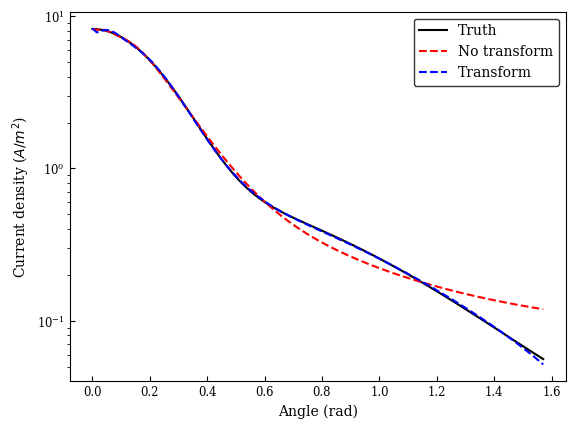

In [91]:
fig, ax = plt.subplots()
alpha_rad = np.linspace(0, np.pi/2, 100)
ax.plot(alpha_rad, at, '-k', label='Truth')
ax.plot(alpha_rad, ahat_t, '--r', label='No transform')
ax.plot(alpha_rad, g_inv(bhat_t), '--b', label='Transform')
ax.set_yscale('log')
ax_default(ax, 'Angle (rad)', 'Current density ($A/m^2$)', legend=True)
plt.show()

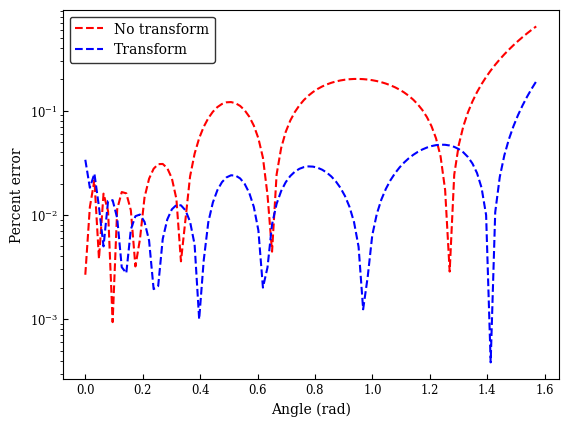

In [63]:
eps_a = np.abs(ahat_t - at) / at
eps_g = np.abs(g_inv(bhat_t) - at) / at
fig, ax = plt.subplots()
ax.plot(alpha_rad, eps_a, '--r', label='No transform')
ax.plot(alpha_rad, eps_g, '--b', label='Transform')
ax.set_yscale('log')
ax_default(ax, 'Angle (rad)', 'Percent error', legend=True)
plt.show()